In [1]:
import numpy as np
import scipy.io as sio
import os
import euGenFuncs as eu
import numpy as np
import pandas as pd
import pickle
import ieeg_funcs as ief
import dgFuncs as dg
from scipy.interpolate import UnivariateSpline
from scipy.stats import iqr
import matplotlib.pyplot as plt
%matplotlib inline
import imp 

In [3]:
## LOAD KMEANS DATA & TRY BRUTE FORCE THRESHOLDING TO DISCRIMINATE CLASSES
# list of subs
# subs=[253, 264]
#subs=[1077, 1096, 1125, 115, 253, 264, 273, 442, 565, 590, 620, 862, 922, 958, 970]


# Get file list & figure out max and min feature values
in_fnames=list() # List of kdownsampled*.npz files (1 per sub)
sub_list=list() # Corresponding list of subs
# find all subsamp files
in_dir='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/'
f_ct=0
for f in os.listdir(in_dir):
    if f.startswith('kdownsampled_'):
        in_fnames.append(f)
        tmp=f.split('_')[1]
        sub_list.append(int(tmp.split('.')[0]))
        mat=np.load(os.path.join(in_dir,f))
        if f_ct==0:
            min_ftrs=np.min(mat['ftrs_dsamp'],axis=0) # 30 dim vector
            max_ftrs=np.max(mat['ftrs_dsamp'],axis=0) # 30 dim vector
        else:
            min_ftrs=np.minimum(min_ftrs,np.min(mat['ftrs_dsamp'],axis=0)) # 30 dim vector
            max_ftrs=np.maximum(max_ftrs,np.max(mat['ftrs_dsamp'],axis=0)) # 30 dim vector
        f_ct+=1
        
n_band=6
band_labels=['Delta','Theta','Alpha','Beta','Gamma','HGamma']
n_edm=5
n_ftr=n_band*n_edm
n_file=len(in_fnames)
print('%d files total' % n_file)

bin_edge_list=list()
n_bin_list=list()
n_targ_bin=500 #?? make bigger
ictal_p_list=list()
nonictal_p_list=list()
label_list=list()
bin_cntr_list=list()
acc_list=list()
for a in range(n_ftr):
    bin_cntr_list.append([])
    
# Create the histogram edges. Edges may differ across feature but are the same across subs
for edm_ct in range(n_edm):
    for b_ct in range(n_band):
        bin_edge_list.append(np.linspace(min_ftrs[b_ct+edm_ct*n_band],max_ftrs[b_ct+edm_ct*n_band],n_targ_bin))
        #bin_edge_list.append(np.logspace(min_ftrs[b_ct+edm_ct*n_band],max_ftrs[b_ct+edm_ct*n_band],n_targ_bin))
        n_bin_list.append(len(bin_edge_list[-1]))
        label_list.append(band_labels[b_ct]+'-EDM'+str(edm_ct))
        acc_list.append(np.zeros((n_file,n_bin_list[-1])))

        
# Loop over features and find best threshold for class discrimination
n_wind=np.zeros(n_ftr)
for f_ct, f in enumerate(in_fnames):
    mat=np.load(os.path.join(in_dir,f))
    n_wind[f_ct]=mat['ftrs_dsamp'].shape[0]
    
    # Loop over features
    for edm_ct in range(n_edm):
    #for edm_ct in range(1):
        raw_ftrs=mat['ftrs_dsamp'].T
        for b_ct in range(n_band):
            sens=np.zeros(len(bin_edge_list[b_ct+edm_ct*n_band]))
            spec=np.zeros(len(bin_edge_list[b_ct+edm_ct*n_band]))
            for thresh_ct, thresh in enumerate(bin_edge_list[b_ct+edm_ct*n_band]):
                    y_hat=(raw_ftrs[b_ct+edm_ct*n_band,:]>=thresh)
                    sens[thresh_ct]=np.mean(y_hat[mat['szr_class_dsamp']==1])
                    spec[thresh_ct]=np.mean(y_hat[mat['szr_class_dsamp']==0]==0)
            acc=np.abs(-.5+(sens+spec)/2)
            acc_list[b_ct+edm_ct*n_band][f_ct,:]=acc
#                     # Compute hist and spline
#                     #s=-2+raw_ftrs[b_ct+edm_ct*n_band,mat['szr_class_dsamp']==ictal]/3

#                     # Normalize
#                     #s=-2+(s-np.median(s))/(3*iqr(s))
#                     #p, x = np.histogram(s, bins=n_bin) 
#                     #p, x = np.histogram(s, bins=bin_edge_list[b_ct+edm_ct*n_band]) # bin it into n = N/10 bins
#                     #x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
#                     #bin_cntr_list[b_ct+edm_ct*n_band]=x

print('Done!')

8 files total
Done!


In [ ]:
# Plot accuracy (single sub & mean) as a function of threshold
# plt.figure(1)
# plt.clf()
# # plt.imshow(acc_list[0])
# plt.plot(bin_edge_list[0],acc_list[0].T);
# plt.plot(bin_edge_list[0],np.mean(acc_list[0],axis=0),'k-')

# plt.figure(2)
# plt.clf()
# plt.plot(bin_edge_list[-1],acc_list[-1].T);
# plt.plot(bin_edge_list[-1],np.mean(acc_list[-1],axis=0),'k-')

In [5]:
# Import desired upper and lower bounds
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/ftr_limits.csv'
ftr_lims=pd.read_csv(in_fname,sep=',')
ftr_lims.head()

,FEATURE,UPPER THRESHOLD,MIN VALUE
0,Delta-EDM0,150,-6.720119
1,Theta-EDM0,300,-7.867271
2,Alpha-EDM0,400,-10.222829
3,Beta-EDM0,500,-17.373436
4,Gamma-EDM0,400,-16.053899


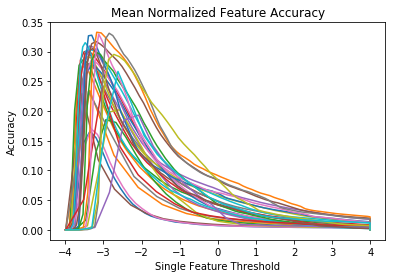

In [6]:
# Loop over each feature and figure out what translation and division factor should be
cntr=np.zeros(n_ftr)
div_fact=np.zeros(n_ftr)
plt.figure(10)
plt.clf()
for f_ct in range(n_ftr):
    low_bnd=ftr_lims.iloc[f_ct,2]
    up_bnd=ftr_lims.iloc[f_ct,1]
    

    # Re-center bins
    ftr_vals=bin_edge_list[f_ct]
    ftr_vals[ftr_vals>up_bnd]=up_bnd;
    ftr_vals[ftr_vals<low_bnd]=low_bnd;
    rng=up_bnd-low_bnd;
    div_fact[f_ct]=rng/(2*3.99)
    ftr_vals=ftr_vals/div_fact[f_ct]
    
    cntr[f_ct]=-3.99-ftr_vals[0] # add this to feature value to make min possible value=-3.99
    ftr_vals=ftr_vals+cntr[f_ct]
    
#     print('new rng %f' % (np.max(ftr_vals)-np.min(ftr_vals)))
#     ftr_vals=ftr_vals+cntr[f_ct]
#     tmp_up_bnd=up_bnd+cntr[f_ct]
#     div_fact[f_ct]=tmp_up_bnd/3.99 # divide feature by this value to make max possible value=3.99
    
    #plt.plot(bin_edge_list[-1],np.mean(acc_list[-1],axis=0),'k-')
    #mn=np.mean(acc_list[f_ct],axis=0)


    plt.plot(ftr_vals,np.mean(acc_list[f_ct],axis=0))
    plt.xlabel('Single Feature Threshold')
    plt.ylabel('Accuracy')
    plt.title('Mean Normalized Feature Accuracy')
    
# print(ftr_vals[0])
# print(ftr_vals[-1])    

# Save normalization parameters to disk
out_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/norm_factors.npz'
np.savez(out_fname,cntr=cntr,div_fact=div_fact,ftr_labels=label_list,in_fnames=in_fnames)

In [7]:
bro=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/norm_factors.npz')
bro.keys()

['ftr_labels', 'cntr', 'div_fact', 'in_fnames']

In [8]:
path_dict=ief.get_path_dict()
path_dict.keys()

dict_keys(['onset_csv', 'ftrs_root', 'eu_meta', 'pics', 'eu_root', 'eu_gen_ftrs', 'ieeg_root', 'szr_ant_root'])

In [9]:
path_dict['szr_ant_root']

'/Users/davidgroppe/PycharmProjects/SZR_ANT/'

In [10]:
nrm_fname=os.path.join(path_dict['szr_ant_root'],'EU_GENERAL','KDOWNSAMP','norm_factors.npz')
print(nrm_fname)

/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/norm_factors.npz


In [11]:
bro=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/train_ftrs_aes.npz')
bro.keys()

['ftrs', 'szr_class', 'sub_id', 'train_subs_list']

In [12]:
bro['ftrs'].shape

(742579, 30)

In [14]:
sis=np.max(bro['ftrs'],axis=0)
sis.shape

(30,)

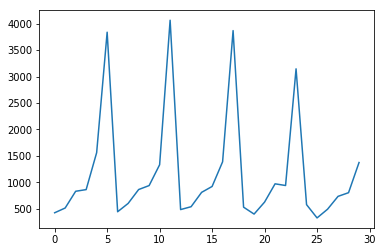

In [15]:
plt.figure(22)
plt.clf()
plt.plot(sis)

In [19]:
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/dude.pkl'
bro=pickle.load(open(in_fname,'rb'))
bro.keys()

dict_keys(['szr_file_chans', 'grand_szr_fnames', 'szr_file_subs', 'grand_non_fnames', 'non_file_chans', 'non_file_subs', 'grand_n_szr_wind', 'ftr_dim', 'grand_n_non_wind'])

In [36]:
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/train_ftrs_aes.npz'
bro=np.load(in_fname)
bro.keys()

['sub_id', 'ftrs', 'szr_class', 'train_subs_list']

In [37]:
print(bro['ftrs'].shape)
mx=np.max(bro['ftrs'],axis=0)
print(mx.shape)
ftr_min=np.min(bro['ftrs'],axis=0)

(742579, 30)
(30,)


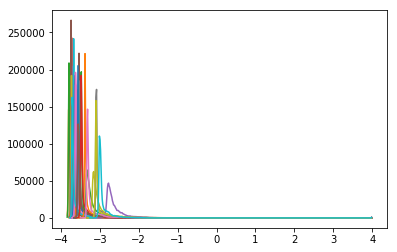

In [50]:
plt.figure(10)
plt.clf()
for a in range(30):
    hist, bin_edges=np.histogram(bro['ftrs'][:,a],bins=500)
    bin_cntrs=(bin_edges[1:]+bin_edges[0:-1])/2
    plt.plot(bin_cntrs,hist)
    

In [51]:
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/kdownsampled_1077.npz'
bro=np.load(in_fname)
bro.keys()

['szr_class_dsamp', 'ftrs_dsamp', 'dsamp_wts']

In [52]:
bro['ftrs_dsamp'].shape

(2696, 30)

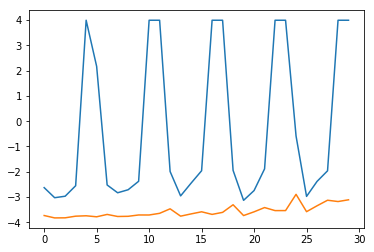

In [56]:
plt.figure(1)
plt.clf()
plt.plot(np.max(bro['ftrs_dsamp'],axis=0))
plt.plot(np.min(bro['ftrs_dsamp'],axis=0))